In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np

import requests
from bs4 import BeautifulSoup
import re
import time
import os

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False

### 데이터를 불러온다.

In [2]:
pitcher = pd.read_csv('data10/picher_stats_2017.csv')
pitcher

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,장민재,한화,2,5,0,0,2,33,5,62.2,...,1.58,0.355,56.9,7.76,-1.21,6.21,6.48,-0.47,7100,8100
148,정용운,KIA,3,2,0,0,0,25,11,59.1,...,1.06,0.263,65.4,5.92,0.39,6.41,6.77,-0.49,7500,3100
149,노경은,롯데,0,2,0,0,0,9,2,14.2,...,2.45,0.382,52.8,11.66,-0.83,8.03,8.29,-0.61,10000,16000
150,김승현,삼성,0,3,0,1,0,41,0,43.2,...,1.44,0.341,73.9,5.77,-0.40,6.87,6.95,-0.70,4000,2900


In [3]:
# 불필요한 컬럼을 제거
pitcher_df = pitcher.drop('선수명', axis=1)
pitcher_df.columns

Index(['팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9',
       '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

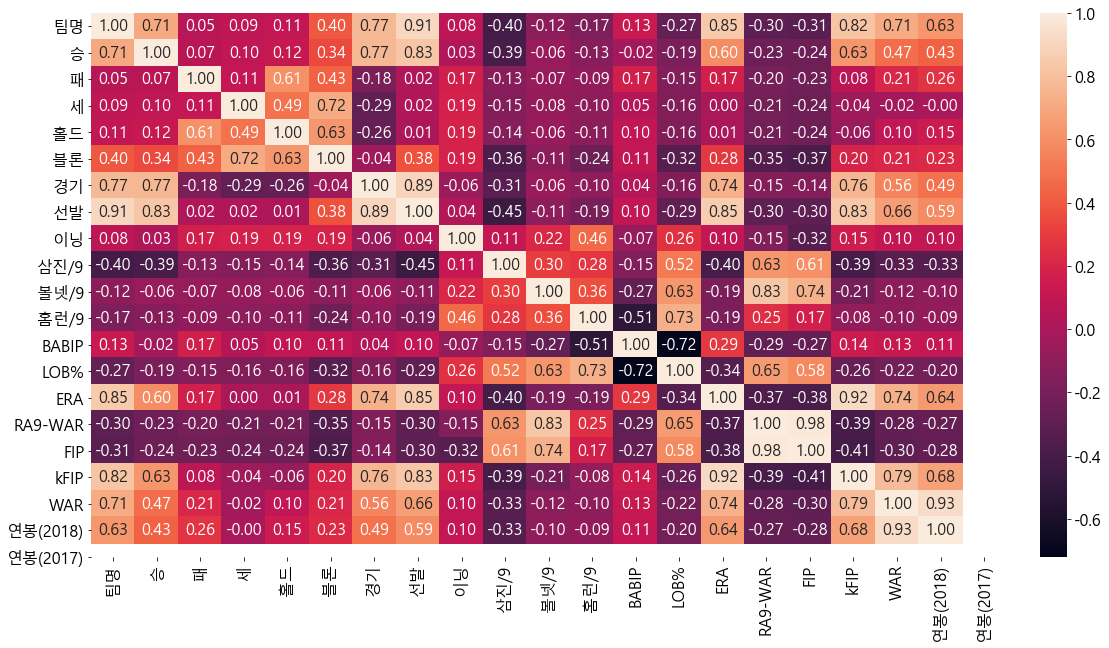

In [4]:
# 상관관계 파악
# 상관계수를 구한다.
corr = pitcher_df.corr(method='pearson')
# heatmap
sns.heatmap(corr.values, cbar=True, annot=True, fmt='.2f', yticklabels=pitcher_df.columns, xticklabels=pitcher_df.columns)
plt.show()

In [5]:
# 입력과 결과로 나눈다.

# VIF 계수 측정을 위해 수치 높은 컬럼들을 제거한다.
pitcher_df = pitcher_df.drop(['kFIP', '이닝', 'FIP', 'RA9-WAR', '선발'], axis=1)

X = pitcher_df.drop('연봉(2018)', axis=1)
y = pitcher_df['연봉(2018)']


display(X)
display(y)

,팀명,승,패,세,홀드,블론,경기,삼진/9,볼넷/9,홈런/9,BABIP,LOB%,ERA,WAR,연봉(2017)
0,SK,16,7,0,0,0,30,8.95,2.13,0.76,0.342,73.7,3.60,6.62,85000
1,LG,11,11,1,0,0,30,7.43,1.85,0.53,0.319,67.1,3.88,6.08,50000
2,KIA,20,6,0,0,0,31,7.36,2.09,0.79,0.332,72.1,3.44,5.64,150000
3,LG,10,7,0,0,0,28,8.04,1.95,1.02,0.298,75.0,3.43,4.63,100000
4,롯데,13,7,0,0,0,30,7.49,2.11,0.91,0.323,74.1,3.80,4.38,85000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,한화,2,5,0,0,2,33,4.31,3.30,1.58,0.355,56.9,7.76,-0.47,8100
148,KIA,3,2,0,0,0,25,4.85,5.61,1.06,0.263,65.4,5.92,-0.49,3100
149,롯데,0,2,0,0,0,9,4.91,4.91,2.45,0.382,52.8,11.66,-0.61,16000
150,삼성,0,3,0,1,0,41,7.63,7.01,1.44,0.341,73.9,5.77,-0.70,2900


0      140000
1      120000
2      230000
3      100000
4      111000
        ...  
147      7100
148      7500
149     10000
150      4000
151      4000
Name: 연봉(2018), Length: 152, dtype: int64

In [6]:
# 팀명을 숫자로 변환한다.
from sklearn.preprocessing import LabelEncoder

encoder1 = LabelEncoder()
encoder1.fit(X['팀명'])
X['팀명'] = encoder1.transform(X['팀명'])
X['팀명'].value_counts()


8    20
7    20
1    19
4    18
2    18
5    15
0    15
6    14
3    13
Name: 팀명, dtype: int64

In [7]:
# 표준화작업
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
scaler1.fit(X)
X = scaler1.transform(X)
X

array([[-0.04225053,  3.32457765,  1.23120199, ..., -0.58899636,
         4.51802888,  2.74374569],
       [-0.7977895 ,  2.02618144,  2.51300132, ..., -0.52157386,
         4.10827019,  1.34172411],
       [-1.55332846,  4.36329461,  0.91075216, ..., -0.6275235 ,
         3.77439273,  5.34750005],
       ...,
       [ 0.71328843, -0.8302902 , -0.37104718, ...,  1.35180842,
        -0.9681847 , -0.02023971],
       [ 1.09105791, -0.8302902 , -0.05059734, ..., -0.06647199,
        -1.03647782, -0.54499636],
       [-1.17555898,  0.20842676,  0.26985249, ...,  0.39103782,
        -1.27170966, -0.54099058]])

In [8]:
# VIF 계수 : 다중공선성 정도를 계산하여 제공하는 수치
# 다중공선성 ; 회귀 분석에서 사용된 모형의 일부 변수가 다른 변수와 상관 정도가 높아
# 데이터 분석시 부정적인 영향을 미치는 현상
# VIF 계수가 낮을 수록 독립적으로 판단할 수 있다.

from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계수를 담을 데이터 프레임
vif = pd.DataFrame()`
vif['VIF Factor'] = [variance_inflation_factor(X, i) for i in range(len(X[0]))]
vif['features'] = pitcher_df.drop('연봉(2018)', axis=1).columns
vif

,VIF Factor,features
0,1.099048,팀명
1,5.446974,승
2,2.302396,패
3,2.422472,세
4,2.931233,홀드
5,2.586750,블론
6,5.046875,경기
7,1.686140,삼진/9
8,2.049889,볼넷/9
9,2.354659,홈런/9


VIF 계쑤를 보고 선정하는 방법
- VIF 계수가 높은 피처들을 우선적으로 제거한다
- 단, (FIP, kFIP)와 같이 유사한 두가지 피처중에는 하나만 제거한다.
- 다시 VIF를 구한다.
- 계속 반복하며 VIF 계수가 높은것들을 제거한다.
- VIF 계수가 만족하는 정도로 비슷한 수준이면 

In [10]:
from sklearn.model_selection import train_test_split

# 학습용과 검증용으로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=1)


In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# 폴드 생성
kfold = KFold(n_splits=20, shuffle=True, random_state=1)

# 하이퍼 파라미터 튜닝
params = {
    # 트리의 개수
    'n_estimators' : [10, 50, 100, 150, 200],
    # 질문 깊이
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# 모델 생성
model = XGBRegressor(silent=True, verbosity=0, tree_method='gpu_hist')

# 하이퍼파라미터 튜닝
grid = GridSearchCV(model, param_grid=params, scoring='r2', cv=kfold)
grid.fit(X_train, y_train)

print(f'최적의 하이퍼 파라미터 : {grid.best_params_}')
print(f'최적의 모델 평균 성능 : {grid.best_score_}')


최적의 하이퍼 파라미터 : {'max_depth': 5, 'n_estimators': 200}
최적의 모델 평균 성능 : 0.802357935146914


In [12]:
# 최적의 하이퍼파라미터가 셋팅된 모델을 추출한다.
best_model = grid.best_estimator_
best_model


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=True, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=0)

In [16]:
# 교차검증
result = cross_val_score(best_model, X_train, y_train, scoring='r2', cv=kfold)
result

array([0.78600535, 0.27815177, 0.84654585, 0.81062123, 0.59040293,
       0.75326526, 0.91426761, 0.87810541, 0.60871126, 0.58107174,
       0.76670085, 0.98423974, 0.97484224, 0.79443304, 0.98673102,
       0.94920094, 0.94707708, 0.96825342, 0.76100512, 0.86752685])

In [17]:
# 데이터를 학습 시킨다.
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=True, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=0)

In [18]:
# 결과를 예측한다.
y_pred = best_model.predict(X_test)
y_pred

array([14709.331 , 23219.463 ,  3131.118 ,  7776.496 ,  7255.3184,
        2674.518 ,  3434.462 , 19337.    ,  5760.111 , 50659.594 ,
       10426.644 ,  6643.5703,  3271.6025,  4502.9844, 24546.21  ,
        5616.2026, 23056.055 ,  3254.1226,  3180.619 ,  2790.9104,
        3595.399 ,  5932.643 ,  3867.1475,  3591.061 ,  2968.844 ,
       18989.773 , 14723.901 , 17864.252 ,  6585.9233,  4480.8057,
       10273.514 ], dtype=float32)

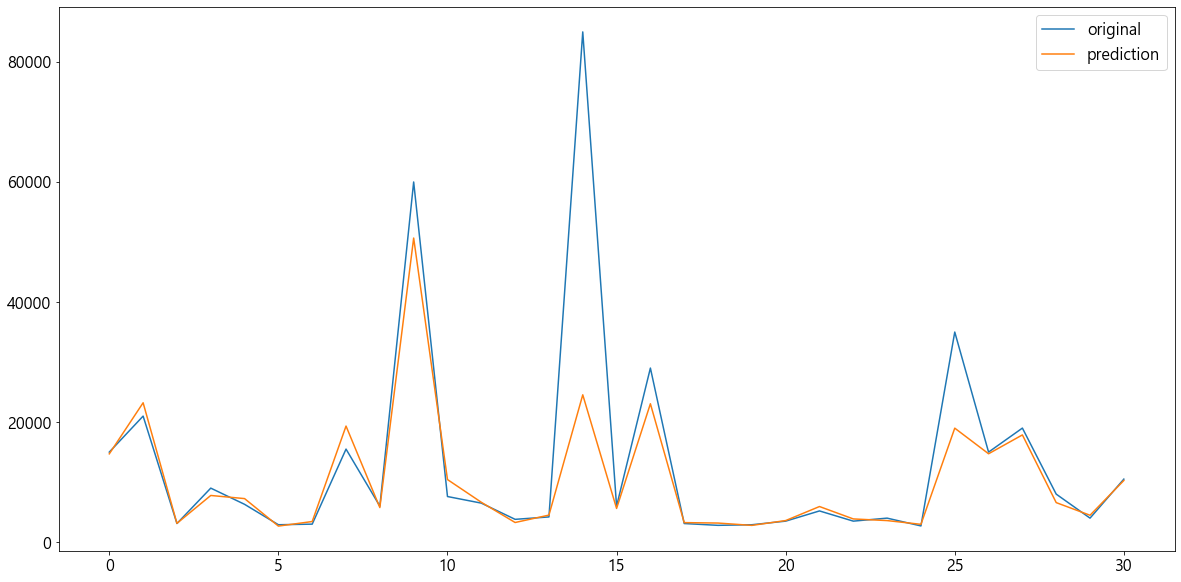

In [19]:
# 진짜 결과와 예측 결과를 그래프로 확인한다.
plt.plot(y_test.values, label='original')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()